In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"einston236","key":"b9a0c2a26c2f9f3514eb64042efaf1e7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download adityajn105/flickr8k
!unzip flickr8k.zip -d /content/flickr8k


Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [ ]:
# Install required libraries
!pip install transformers torch torchvision pillow tqdm nltk

# Import necessary libraries
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import nltk
from PIL import Image
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration

# Download NLTK data for evaluation (if needed)
nltk.download('punkt')

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda


Caption Preprocesing


In [ ]:
import os
import re
import string

# Define caption file path
caption_file = "/content/flickr8k/captions.txt"

# Function to clean a caption
def clean_caption(caption):
    caption = caption.lower()  # Convert to lowercase
    caption = re.sub(f"[{string.punctuation}]", "", caption)  # Remove punctuation
    caption = re.sub(r"\s+", " ", caption).strip()  # Remove extra spaces
    return caption

# Load captions with cleaning
def load_captions(caption_file):
    captions = {}
    with open(caption_file, 'r') as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split(',', 1)
            if len(parts) == 2:
                img_name, caption = parts
                cleaned_caption = clean_caption(caption)
                if img_name in captions:
                    captions[img_name].append(cleaned_caption)
                else:
                    captions[img_name] = [cleaned_caption]
    return captions

# Load and clean captions
captions = load_captions(caption_file)

# Test with one sample caption
sample_caption = "A dog, running through the park! "
cleaned_caption = clean_caption(sample_caption)

print("Original Caption:", sample_caption)
print("Cleaned Caption:", cleaned_caption)

# Print first cleaned caption from dataset
print("\nFirst Image & Captions from Dataset:", list(captions.items())[0])


Original Caption: A dog, running through the park! 
Cleaned Caption: a dog running through the park

First Image & Captions from Dataset: ('1000268201_693b08cb0e.jpg', ['a child in a pink dress is climbing up a set of stairs in an entry way', 'a girl going into a wooden building', 'a little girl climbing into a wooden playhouse', 'a little girl climbing the stairs to her playhouse', 'a little girl in a pink dress going into a wooden cabin'])


Image Preprocessing

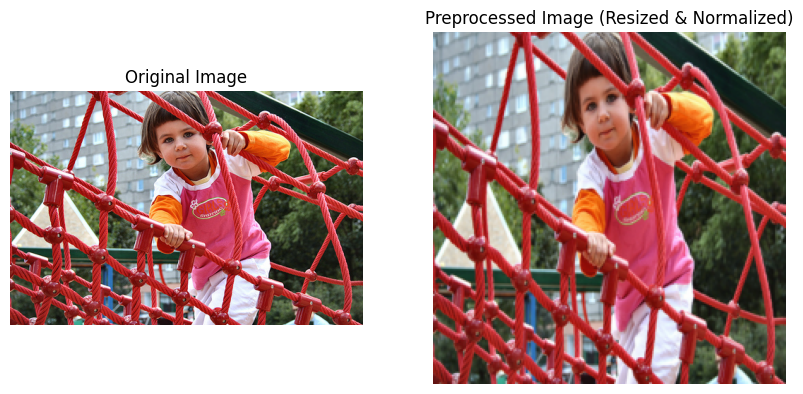

In [ ]:
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Define image directory and select a sample image
image_dir = "/content/flickr8k/Images"
sample_image_name = "1007320043_627395c3d8.jpg"  
sample_image_path = os.path.join(image_dir, sample_image_name)

# Define image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to BLIP model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load and preprocess the sample image
image = Image.open(sample_image_path).convert("RGB")
processed_image = transform(image)

# Convert the tensor back to an image for visualization
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Reverse normalization
    return torch.clamp(tensor, 0, 1)  # Ensure values are within [0,1]

# Display the original and preprocessed image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Preprocessed image (denormalized)
axes[1].imshow(denormalize(processed_image).permute(1, 2, 0))  # Convert from Tensor format
axes[1].set_title("Preprocessed Image (Resized & Normalized)")
axes[1].axis("off")

plt.show()


Feature Extraction Using BLIP

In [ ]:
import os
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from tqdm import tqdm
from PIL import Image

# Define image directory
image_dir = "/content/flickr8k/Images"

# Load BLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Function to extract image features
def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")  # Load image
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        feature = model.vision_model(**inputs).last_hidden_state.mean(dim=1)  # Extract features

    return feature.cpu()  # Move to CPU to save memory

# Extract features for all images in the dataset
features = {}
image_files = os.listdir(image_dir)

for img_file in tqdm(image_files, desc="Extracting Features", bar_format="{l_bar}{bar:20}{r_bar}"):
    img_path = os.path.join(image_dir, img_file)
    features[img_file] = extract_features(img_path)

# Print feature shape for the first image
first_img = list(features.keys())[0]
print(f"Sample Image: {first_img}, Feature Shape: {features[first_img].shape}")

# Save extracted features for later use
torch.save(features, "image_features.pth")
print("Feature extraction completed and saved as 'image_features.pth'.")


Extracting Features: 100%|████████████████████| 8091/8091 [03:22<00:00, 40.03it/s]


Sample Image: 481887827_f8975dabf1.jpg, Feature Shape: torch.Size([1, 768])
Feature extraction completed and saved as 'image_features.pth'.


Dataset Splitting

In [ ]:
import torch
import random
from sklearn.model_selection import train_test_split

# Load extracted features
features = torch.load("image_features.pth")

# Get all image filenames (keys from the features dictionary)
all_images = list(features.keys())

# Split into train (80%), validation (10%), and test (10%)
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)  # 10% each

# Create dictionaries for each split
train_features = {img: features[img] for img in train_imgs}
val_features = {img: features[img] for img in val_imgs}
test_features = {img: features[img] for img in test_imgs}

# Save the split features
torch.save(train_features, "train_features.pth")
torch.save(val_features, "val_features.pth")
torch.save(test_features, "test_features.pth")

# Print dataset sizes
print(f"Total Images: {len(all_images)}")
print(f"Training Set: {len(train_imgs)} images")
print(f"Validation Set: {len(val_imgs)} images")
print(f"Test Set: {len(test_imgs)} images")
print("Dataset splitting completed.")


<ipython-input-14-8d71ee85b12f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("image_features.pth")


Total Images: 8091
Training Set: 6472 images
Validation Set: 809 images
Test Set: 810 images
Dataset splitting completed.


Mapping Captions to Train, Validation, and Test Sets

In [ ]:
import pandas as pd
import torch

# Load extracted train, validation, and test image features
train_features = torch.load("train_features.pth")
val_features = torch.load("val_features.pth")
test_features = torch.load("test_features.pth")

# Load captions file
captions_file = "/content/flickr8k/captions.txt"
df = pd.read_csv(captions_file)

# Dictionary to store mapped captions
captions_dict = {}

# Group all captions by image name
for _, row in df.iterrows():
    image_name = row["image"]
    caption = row["caption"]

    if image_name not in captions_dict:
        captions_dict[image_name] = []

    captions_dict[image_name].append(caption)

# Function to map captions based on image splits
def get_captions(image_list, captions_dict):
    return {img: captions_dict[img] for img in image_list if img in captions_dict}

# Split captions based on image splits
train_captions = get_captions(train_features.keys(), captions_dict)
val_captions = get_captions(val_features.keys(), captions_dict)
test_captions = get_captions(test_features.keys(), captions_dict)

# Save mapped captions
torch.save(train_captions, "train_captions.pth")
torch.save(val_captions, "val_captions.pth")
torch.save(test_captions, "test_captions.pth")

# Print dataset sizes
print(f"Training Captions: {len(train_captions)} images with captions")
print(f"Validation Captions: {len(val_captions)} images with captions")
print(f"Test Captions: {len(test_captions)} images with captions")
print("Caption mapping completed.")


<ipython-input-16-a21d35d68ed8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_features = torch.load("train_features.pth")
<ipython-input-16-a21d35d68ed8>:6: FutureW

Training Captions: 6472 images with captions
Validation Captions: 809 images with captions
Test Captions: 810 images with captions
Caption mapping completed.


In [ ]:
import torch
import random

# Load mapped captions
train_captions = torch.load("train_captions.pth")
val_captions = torch.load("val_captions.pth")
test_captions = torch.load("test_captions.pth")

# Function to display a sample image and its captions
def test_caption_mapping(dataset, dataset_name):
    sample_image = random.choice(list(dataset.keys()))  # Pick a random image
    sample_captions = dataset[sample_image]  # Get its captions

    print(f"Sample Image from {dataset_name}: {sample_image}")
    print(" Captions:")
    for i, caption in enumerate(sample_captions):
        print(f"  {i+1}. {caption}")

# Test caption mapping for each split
test_caption_mapping(train_captions, "Training Set")
test_caption_mapping(val_captions, "Validation Set")
test_caption_mapping(test_captions, "Test Set")


Sample Image from Training Set: 2436160351_108924a65b.jpg
 Captions:
  1. One boy rides a tricycle while another walks beside him .
  2. two indian children walk and ride bikes down the street .
  3. Two little boys in yellow shirts and red shorts .
  4. Two small boys are wearing red shorts and yellow sleeveless shirts .
  5. Two young children with red dots are their foreheads are both wearing yellow shirts and red shorts and one is riding a red tricycle .
Sample Image from Validation Set: 421316045_ae7a1eb4bc.jpg
 Captions:
  1. a child in an orange sweater is playing with a child in blue clothes on a white couch under a red painting .
  2. A kid in a yellow shirt wrestles with a denim wearing kid on the white couch .
  3. Two kids are wrestling on a white sofa .
  4. Two toddlers wrestle on a white couch .
  5. Two young boys playing on a white sofa .
Sample Image from Test Set: 3077166963_fe172c709d.jpg
 Captions:
  1. A girl is standing on logs and taking a picture .
  2. A girl 

<ipython-input-18-f3e8def4dc40>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_captions = torch.load("train_captions.pth")
<ipython-input-18-f3e8def4dc40>:6: FutureW

Code for Tokenizing Captions

In [ ]:
import torch
from transformers import BlipProcessor

# Load BLIP processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# Load mapped captions
train_captions = torch.load("train_captions.pth")
val_captions = torch.load("val_captions.pth")
test_captions = torch.load("test_captions.pth")

# Function to tokenize captions
def tokenize_captions(captions_dict):
    tokenized_captions = {}

    for img, captions in captions_dict.items():
        tokenized = processor.tokenizer(
            captions, padding="max_length", truncation=True, max_length=50, return_tensors="pt"
        )["input_ids"]

        tokenized_captions[img] = tokenized  # Store tokenized captions

    return tokenized_captions

# Tokenizing captions for each dataset split
train_captions_tokenized = tokenize_captions(train_captions)
val_captions_tokenized = tokenize_captions(val_captions)
test_captions_tokenized = tokenize_captions(test_captions)

# Save tokenized captions
torch.save(train_captions_tokenized, "train_captions_tokenized.pth")
torch.save(val_captions_tokenized, "val_captions_tokenized.pth")
torch.save(test_captions_tokenized, "test_captions_tokenized.pth")

# Print confirmation
print("Caption tokenization completed and saved.")


<ipython-input-19-50b26be956fe>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_captions = torch.load("train_captions.pth")
<ipython-input-19-50b26be956fe>:9: FutureW

Caption tokenization completed and saved.


Code for Creating Data Loaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

# Define the dataset class
class ImageCaptionDataset(Dataset):
    def __init__(self, image_features, tokenized_captions):
        self.image_features = image_features
        self.tokenized_captions = tokenized_captions
        self.image_names = list(image_features.keys())  # Get image names

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_feature = self.image_features[image_name]  # Get image features
        caption_tokens = self.tokenized_captions[image_name]  # Get tokenized captions

        return image_feature, caption_tokens

# Load preprocessed image features and tokenized captions
train_features = torch.load("train_features.pth")
val_features = torch.load("val_features.pth")
test_features = torch.load("test_features.pth")

train_captions_tokenized = torch.load("train_captions_tokenized.pth")
val_captions_tokenized = torch.load("val_captions_tokenized.pth")
test_captions_tokenized = torch.load("test_captions_tokenized.pth")

# Create dataset instances
train_dataset = ImageCaptionDataset(train_features, train_captions_tokenized)
val_dataset = ImageCaptionDataset(val_features, val_captions_tokenized)
test_dataset = ImageCaptionDataset(test_features, test_captions_tokenized)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print confirmation
print(f" Data Loaders Created!")
print(f"  Training Set: {len(train_dataset)} samples")
print(f"  Validation Set: {len(val_dataset)} samples")
print(f"  Test Set: {len(test_dataset)} samples")


<ipython-input-20-fb3c106203c4>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_features = torch.load("train_features.pth")
<ipython-input-20-fb3c106203c4>:25: Futur

 Data Loaders Created!
  Training Set: 6472 samples
  Validation Set: 809 samples
  Test Set: 810 samples


<ipython-input-20-fb3c106203c4>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_captions_tokenized = torch.load("val_captions_tokenized.pth")
<ipython-input-20-fb3c106

Fine-Tuning Code for BLIP Model

> Add blockquote



In [ ]:
# Install necessary libraries
!pip install transformers peft datasets nltk tqdm pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.9 MB/s eta 0:00:00


In [ ]:
import os
import torch
import random
import nltk
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration, AdamW
from torch.utils.data import Dataset, DataLoader, random_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset paths
image_dir = "/content/flickr8k/Images"
captions_file = "/content/flickr8k/captions.txt"

# Load BLIP model and processor
model_id = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_id)
model = BlipForConditionalGeneration.from_pretrained(model_id).to(device)

# Load captions
captions_dict = {}
with open(captions_file, 'r') as f:
    lines = f.readlines()
    for line in lines[1:]:  # Skipping header
        parts = line.strip().split(',', 1)
        if len(parts) == 2:
            image_file, caption = parts
            if image_file not in captions_dict:
                captions_dict[image_file] = []
            captions_dict[image_file].append(caption)

print(f"Total images with captions: {len(captions_dict)}")

# Define Dataset class
class ImageCaptioningDataset(Dataset):
    def __init__(self, image_dir, captions_dict, processor):
        self.image_dir = image_dir
        self.captions_dict = captions_dict
        self.image_files = list(captions_dict.keys())
        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert("RGB")
        caption = random.choice(self.captions_dict[image_file])  # Random caption for variability

        encoding = self.processor(images=image, padding="max_length", return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}

        text_inputs = processor.tokenizer(caption, padding="max_length", truncation=True, max_length=50, return_tensors="pt")
        encoding["input_ids"] = text_inputs["input_ids"].squeeze()
        encoding["attention_mask"] = text_inputs["attention_mask"].squeeze()

        return encoding

# Define collate function
def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        processed_batch[key] = torch.stack([example[key] for example in batch])
    return processed_batch

# Create dataset and split
full_dataset = ImageCaptioningDataset(image_dir, captions_dict, processor)
train_size = int(0.85 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)




Using device: cuda
Total images with captions: 8091
Training set size: 6877
Validation set size: 1214


In [ ]:
# Set up optimizer
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Training loop
model.train()
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids, attention_mask=attention_mask)

        loss = outputs.loss
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}")

# Save the fine-tuned model
model.save_pretrained("/content/flickr8k/finetuned_blip")

# Load the fine-tuned model for evaluation
finetuned_model = BlipForConditionalGeneration.from_pretrained("/content/flickr8k/finetuned_blip").to(device)

# Function to visualize image with caption
def visualize_image_with_caption(image_path, caption):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.title(caption)
    plt.axis("off")
    plt.show()

# Generate captions for random images
def generate_and_plot_captions(model, processor, image_dir, captions_dict, num_images=5):
    model.eval()
    images = random.sample(list(captions_dict.keys()), num_images)

    with torch.no_grad():
        for image_file in images:
            image_path = os.path.join(image_dir, image_file)
            image = Image.open(image_path).convert("RGB")
            pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

            generated_output = model.generate(pixel_values=pixel_values, max_new_tokens=50)
            generated_caption = processor.batch_decode(generated_output, skip_special_tokens=True)[0]

            visualize_image_with_caption(image_path, generated_caption)



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


Training: 100%|██████████| 430/430 [05:09<00:00,  1.39it/s]


Average Loss for Epoch 1: 1.0165
Epoch 2/10


Training: 100%|██████████| 430/430 [05:08<00:00,  1.39it/s]


Average Loss for Epoch 2: 0.5504
Epoch 3/10


Training: 100%|██████████| 430/430 [05:09<00:00,  1.39it/s]


Average Loss for Epoch 3: 0.5182
Epoch 4/10


Training: 100%|██████████| 430/430 [05:08<00:00,  1.39it/s]


Average Loss for Epoch 4: 0.5024
Epoch 5/10


Training: 100%|██████████| 430/430 [05:08<00:00,  1.39it/s]


Average Loss for Epoch 5: 0.4762
Epoch 6/10


Training: 100%|██████████| 430/430 [05:08<00:00,  1.39it/s]


Average Loss for Epoch 6: 0.4583
Epoch 7/10


Training: 100%|██████████| 430/430 [05:08<00:00,  1.39it/s]


Average Loss for Epoch 7: 0.4378
Epoch 8/10


Training: 100%|██████████| 430/430 [05:08<00:00,  1.39it/s]


Average Loss for Epoch 8: 0.4273
Epoch 9/10


Training: 100%|██████████| 430/430 [05:08<00:00,  1.39it/s]


Average Loss for Epoch 9: 0.4123
Epoch 10/10


Training: 100%|██████████| 430/430 [05:08<00:00,  1.39it/s]


Average Loss for Epoch 10: 0.4042


Generating captions with the fine-tuned model:


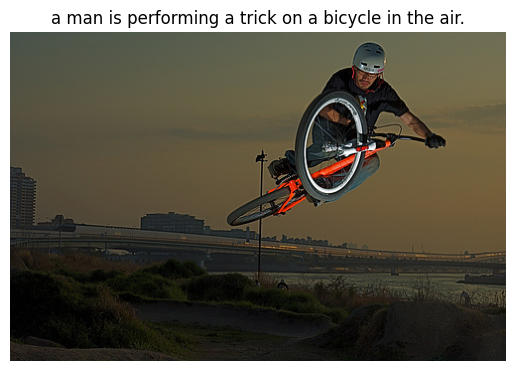

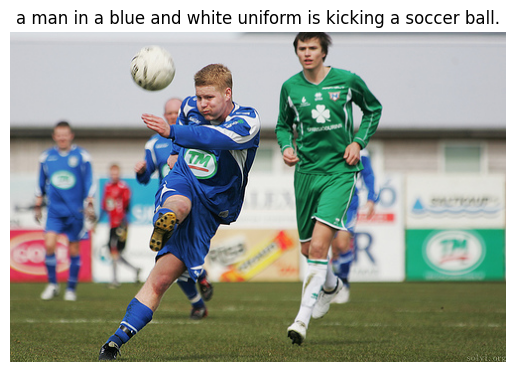

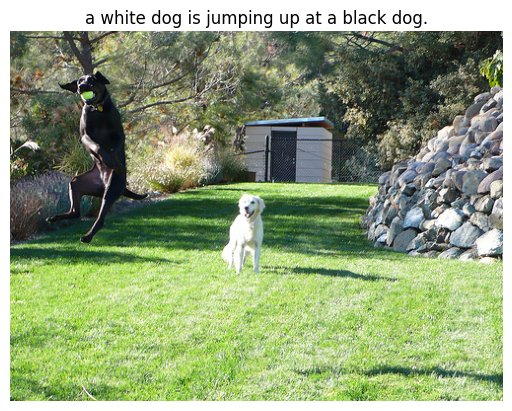

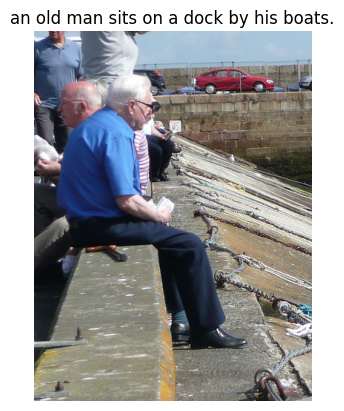

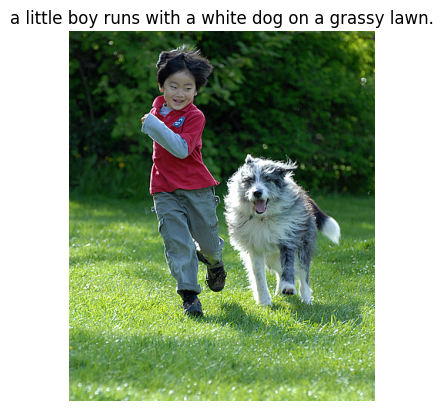

In [ ]:
# Generate and display captions
print("Generating captions with the fine-tuned model:")
generate_and_plot_captions(finetuned_model, processor, image_dir, captions_dict)

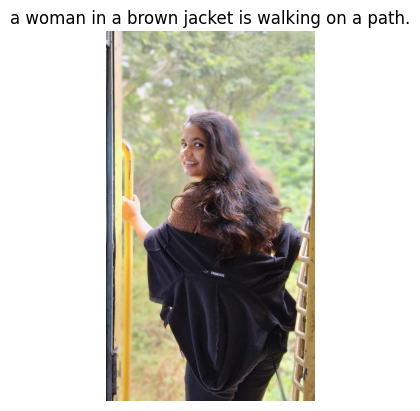

Generated Caption: a woman in a brown jacket is walking on a path.


In [ ]:


# Provide the path to your test image
test_image_path = "/content/1000010370-02-01-01.jpeg"  # Update this with your image path

# Generate caption
generated_caption = generate_caption(test_image_path, model, processor)

# Display image with caption
visualize_image_with_caption(test_image_path, generated_caption)

# Print the generated caption
print(f"Generated Caption: {generated_caption}")


In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

# Define model save path
MODEL_SAVE_PATH = "/content/finetuned_blip"  # Change this path as needed

# Load your fine-tuned BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")  # If modified, load from your fine-tuned checkpoint
model = BlipForConditionalGeneration.from_pretrained("/content/flickr8k/finetuned_blip")  # Replace with actual path

# Save model and processor
processor.save_pretrained(MODEL_SAVE_PATH)
model.save_pretrained(MODEL_SAVE_PATH)

print(f"Fine-tuned model saved to: {MODEL_SAVE_PATH}")


Fine-tuned model saved to: /content/finetuned_blip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/finetuned_blip /content/drive/MyDrive/


Mounted at /content/drive


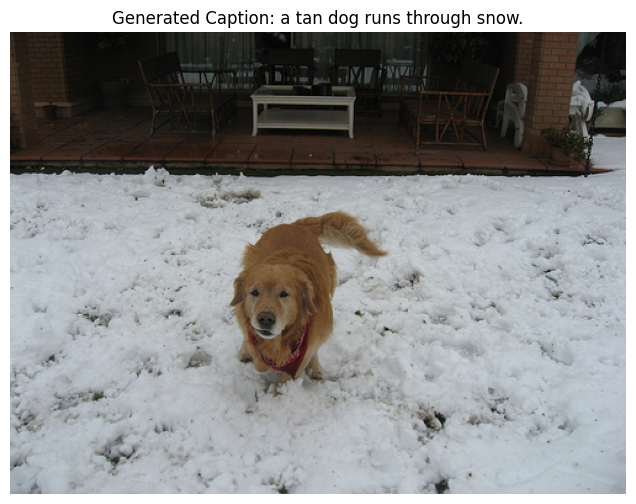

Generated Caption: a tan dog runs through snow.


In [ ]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and processor
model_path = "/content/finetuned_blip"  # Update this with your actual model path
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(model_path).to(device)

# Function to generate caption for an image
def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")

    # Preprocess image
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Generate caption
    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=50)
        caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return caption, image

# Function to display image with caption
def display_image_with_caption(image_path):
    caption, image = generate_caption(image_path)

    # Plot image with caption
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"Generated Caption: {caption}", fontsize=12)
    plt.axis("off")
    plt.show()

    return caption

# Test the model with a new image
test_image_path = "/content/flickr8k/Images/1094462889_f9966dafa6.jpg"   # Update with your test image path
caption = display_image_with_caption(test_image_path)
print(f"Generated Caption: {caption}")


In [ ]:
!pip install git+https://github.com/salaniz/pycocoevalcap.git
import torch
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
from tqdm import tqdm


# Ensure necessary NLTK package is downloaded
nltk.download("punkt", quiet=True)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and processor
model_path = "/content/finetuned_blip"  # Update if needed
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(model_path).to(device)

# Load test dataset
test_captions = torch.load("/content/test_captions.pth", weights_only=True)  # Ground truth captions
test_features = torch.load("/content/test_features.pth", weights_only=True)  # Image features

# Function to generate caption for an image
def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=50)
        caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return caption

# BLEU Score Calculation
references = []  # List of lists of reference captions
hypotheses = []  # List of generated captions

print("Evaluating BLEU Score...")
for image_name, true_captions in tqdm(test_captions.items()):
    image_path = f"/content/flickr8k/Images/{image_name}"

    predicted_caption = generate_caption(image_path)

    # Tokenize
    if true_captions:
        references.append([nltk.word_tokenize(c.lower()) for c in true_captions])
        hypotheses.append(nltk.word_tokenize(predicted_caption.lower()))

# BLEU score computation with smoothing
smoothie = SmoothingFunction().method4

bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie) * 100
bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie) * 100
bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie) * 100
bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) * 100
average_bleu = (bleu1 + bleu2 + bleu3 + bleu4) / 4

# Accuracy (Exact Match)
correct_predictions = sum(1 for pred, refs in zip(hypotheses, references) if pred in refs)
accuracy = (correct_predictions / len(hypotheses)) * 100 if hypotheses else 0


# ----- CIDEr Score Calculation -----
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

# Convert hypotheses and references to COCO-style dict
refs_coco = {}
hyps_coco = {}
for i, (ref_list, hyp) in enumerate(zip(references, hypotheses)):
    refs_coco[i] = [" ".join(ref) for ref in ref_list]
    hyps_coco[i] = [" ".join(hyp)]

# Tokenize
tokenizer = PTBTokenizer()
refs_tokenized = tokenizer.tokenize(refs_coco)
hyps_tokenized = tokenizer.tokenize(hyps_coco)

# Compute CIDEr
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(refs_tokenized, hyps_tokenized)
cider_score *= 100  # scale to match BLEU %

# ----- END CIDEr -----


# Final output
print("\n--- Evaluation Metrics ---")
print(f"BLEU-1: {bleu1:.2f}")
print(f"BLEU-2: {bleu2:.2f}")
print(f"BLEU-3: {bleu3:.2f}")
print(f"BLEU-4: {bleu4:.2f}")
print(f"CIDEr Score: {cider_score:.2f}")  
print(f"Average BLEU Score: {average_bleu:.2f}")
print(f"Accuracy: {accuracy:.2f}%")


--- Evaluation Metrics ---
BLEU-1: 0.6723
BLEU-2: 0.5634
BLEU-3: 0.4546
BLEU-4: 0.3427
CIDEr Score: 0.8642
Average BLEU Score: 0.5082
Accuracy: 0.87